In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import sklearn as sk
from arboreto.utils import load_tf_names

In [2]:
### read original data ###
counts = pd.read_csv('../../OriginalData/seurat.integrated.5Ht_6Ho.counts.csv',index_col=0)
metadata = pd.read_csv('../../OriginalData/seurat.integrated.5Ht_6Ho.metadata.csv',index_col=0)

#Transpose the counts since Anndata expects rows as cells and columns as genes
counts = counts.T

#Create anndata object
adata = ad.AnnData(X=counts,obs=metadata)

#Save/Read the anndata
#adata.write_h5ad('../processed_data/original_data_adata.h5ad')
#adata = sc.read_h5ad('../../../run_Pyscenic/data/original_data_adata.h5ad')

In [3]:
adata
# n_obs × n_vars = 12472 × 19140

AnnData object with n_obs × n_vars = 12472 × 19140
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1'

In [4]:
metadata = adata.obs
# metadata

# Initial preprocessing

In [5]:
min_cells_Ip=5

##Keep cells that express at least 300 genes
sc.pp.filter_cells(adata, min_genes=300 )
##Keep cells that express less than 5000 genes
sc.pp.filter_cells(adata, max_genes=5000 )
##Keep genes that are expressed in at least 5 cells
sc.pp.filter_genes(adata, min_cells=min_cells_Ip)

##Keep cells that have mitochondrial percentage<=10
#adata = adata[adata.obs['percent.mt'] <= 10]

##Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)

## log transform the data - default is natural log, unless specified otherwise
sc.pp.log1p(adata)

# Remove Rik and GM genes

In [6]:
filtered_genes = []
for gene in adata.var_names:
    if not (gene.startswith('Gm') or gene.endswith('Rik') or ('Rik' in gene)):
        filtered_genes.append(gene)

In [7]:
len(filtered_genes)

15321

In [8]:
## Subset the data to remove Rik and GM genes
adata_filtered = adata[:,list(filtered_genes)].copy()
adata_filtered

AnnData object with n_obs × n_vars = 12274 × 15321
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

# Subset for basal cells and remove cells that express PTPRC

In [9]:
## Subset the data for basal cells only
adata_filtered_basal = adata_filtered[adata_filtered.obs['cluster1']=='Mammary epithelial cells-Basal']

## Remove cells with Ptprc > 0 in basal cells
ptprc_expr = adata_filtered_basal[:, "Ptprc"].X  # This should be an array of shape [n_cells, 1]

##Define a boolean mask specifying which cells to keep -> all cells with Ptprc == 0 (no expression):. 
cells_to_keep = (ptprc_expr == 0).ravel()
cells_to_keep

##Subset the AnnData object to only keep the cells that do NOT express Ptprc
adata_filtered_basal = adata_filtered_basal[cells_to_keep, :].copy()
adata_filtered_basal

## Remove cells with Adgre1 > 0 in basal cells
Adgre1_expr = adata_filtered_basal[:, "Adgre1"].X  # This should be an array of shape [n_cells, 1]

##Define a boolean mask specifying which cells to keep -> all cells with Ptprc == 0 (no expression):. 
cells_to_keep_wo_adgre1 = (Adgre1_expr == 0).ravel()

##Subset the AnnData object to only keep the cells that do NOT express Ptprc
adata_filtered_basal = adata_filtered_basal[cells_to_keep_wo_adgre1, :].copy()
adata_filtered_basal

##Save the data
# adata_filtered_basal.write_h5ad('../../Processed_Data/combined_data_basal_5ht6ho_without_PTPRC_Adgre1.h5ad')
#Repeat the below steps for basal cells - find hvg for combined, 5ht and 6ho. Take union. Then compare with list of 4838 genes.

AnnData object with n_obs × n_vars = 1510 × 15321
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

# Ensure selected cells are basal using cell annotation

In [10]:
##Load the file if needed
# adata_filtered_basal = sc.read_h5ad('../../Processed_Data/combined_data_basal_5ht6ho_without_PTPRC_Adgre1.h5ad')

#Load 5Ht cell annotation results
annot_5ht = pd.read_csv('../../Results/Cell_annotation_Ke/5Ht_with_annotation.csv',index_col=0)
#Standardize cell ID for matching
updated_cell_ids = [cell.replace('.','-') for cell in annot_5ht.index]
annot_5ht.index = updated_cell_ids

#Load 6Ho cell annotation results
annot_6ho = pd.read_csv('../../Results/Cell_annotation_Ke/6Ho_with_annotation_by_5Ht.csv',index_col=0)
#Standardize cell ID for matching
updated_cell_ids = [cell.replace('.','-') for cell in annot_6ho.index]
annot_6ho.index = updated_cell_ids
annot_6ho

#Get list of 5Ht basal cell IDs
basal_5ht_cells = adata_filtered_basal[adata_filtered_basal.obs['orig.ident']=='5Ht']
basal_5ht_cells = basal_5ht_cells.obs.index
print('Number of 5Ht basal cells - ',len(basal_5ht_cells))

#Get list of 6Ho basal cell IDs
basal_6Ho_cells = adata_filtered_basal[adata_filtered_basal.obs['orig.ident']=='6Ho']
basal_6Ho_cells = basal_6Ho_cells.obs.index
print('Number of 6Ho basal cells -',len(basal_6Ho_cells))


#Subset annotation results for basal cells used in Network Analysis - 5Ht
annot_5ht_basal = annot_5ht[annot_5ht.index.isin(basal_5ht_cells)]

#Subset annotation results for basal cells used in Network Analysis - 6ho
annot_6ho_basal = annot_6ho[annot_6ho.index.isin(basal_6Ho_cells)]

Number of 5Ht basal cells -  990
Number of 6Ho basal cells - 520


In [11]:
#Check the predicted IDs of 5Ht cells
annot_5ht_basal['predicted.id'].value_counts()

predicted.id
Myoepithelial            965
Dendritic/Macrophages      7
Luminal-AV                 6
Pericytes                  5
TCells_naive               4
TCells_mem                 3
Name: count, dtype: int64

In [12]:
#Check the predicted IDs of 6Ho cells
annot_6ho_basal['predicted.id'].value_counts()

predicted.id
Myoepithelial            513
Dendritic/Macrophages      3
TCells_naive               3
Luminal-HS                 1
Name: count, dtype: int64

In [13]:
##Remove cells with other annotations:
#Annotations to remove
annot_to_remove = ['Luminal-AV','Pericytes','TCells_naive','TCells_mem','Luminal-HS']

#Find cells to keep for 5Ht
cells_to_keep_5Ht = [c for i,c in enumerate(annot_5ht_basal.index) if annot_5ht_basal['predicted.id'][i] not in annot_to_remove]

#Find cells to keep for 6Ho
cells_to_keep_6Ho = [c for i,c in enumerate(annot_6ho_basal.index) if annot_6ho_basal['predicted.id'][i] not in annot_to_remove]

#Combine the cell IDs
all_cells_to_keep = cells_to_keep_5Ht+cells_to_keep_6Ho

#Subset the filtered data
adata_filtered_basal = adata_filtered_basal[all_cells_to_keep, :].copy()

#Save the data for further analysis
adata_filtered_basal.write_h5ad('../../Processed_Data/combined_data_basal_5ht6ho_without_PTPRC_Adgre1_filtered.h5ad')

#Save the metadata for DGE analysis
adata_filtered_basal.obs.to_csv('../../Processed_Data/metaData_basal_5ht6ho_without_PTPRC_Adgre1_filtered.csv')

print('Number of 5Ht basal cells - ',len(cells_to_keep_5Ht))
print('Number of 6Ho basal cells -',len(cells_to_keep_6Ho))

Number of 5Ht basal cells -  972
Number of 6Ho basal cells - 516


/var/folders/p8/3lq_rnqx0jv5mjvx1w5w86n00000gr/T/ipykernel_9113/1791264238.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells_to_keep_5Ht = [c for i,c in enumerate(annot_5ht_basal.index) if annot_5ht_basal['predicted.id'][i] not in annot_to_remove]
/var/folders/p8/3lq_rnqx0jv5mjvx1w5w86n00000gr/T/ipykernel_9113/1791264238.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells_to_keep_6Ho = [c for i,c in enumerate(annot_6ho_basal.index) if annot_6ho_basal['predicted.id'][i] not in annot_to_remove]


In [14]:
## If things fail below, start to run from here

##Read and obtain 5Ht and 6Ho data from combined data to find HVG (if needed)
#adata_filtered_basal = sc.read_h5ad('../../Processed_Data/combined_data_basal_5ht6ho_without_PTPRC_Adgre1_filtered.h5ad')
ht_adata_basal = adata_filtered_basal[adata_filtered_basal.obs['sample']=='5Ht']
ho_adata_basal = adata_filtered_basal[adata_filtered_basal.obs['sample']=='6Ho']

# Find highly variable genes in adata_filtered_basal

In [15]:
# ht_adata_basal # 1167 × 15321, after removing ptprc, 1030
ho_adata_basal # 574 × 15321, after removing ptprc, 532

View of AnnData object with n_obs × n_vars = 516 × 15321
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


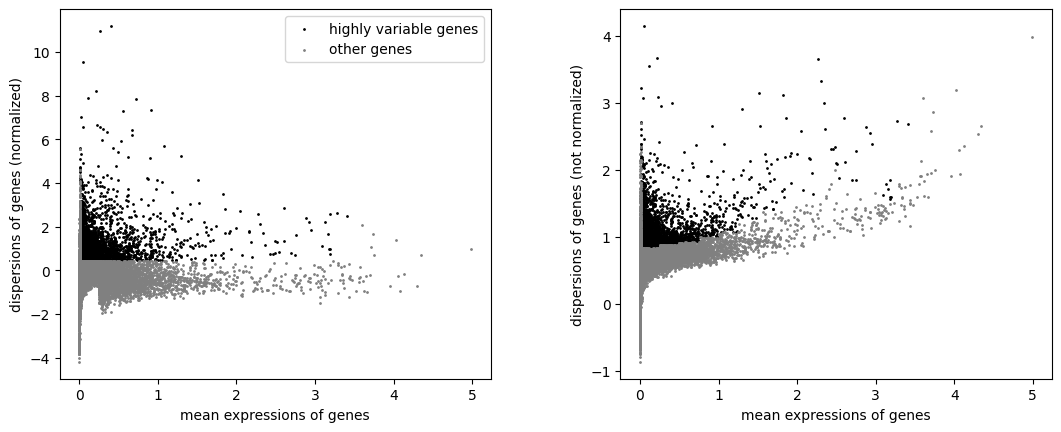

In [16]:
min_disp=0.45
max_mean=3.5
## identify highly variable genes.
sc.pp.highly_variable_genes(adata_filtered_basal, min_mean=0.0125, max_mean=max_mean, min_disp=min_disp) #Absolute value of dispersionis taken, can be seen below.
# sc.pp.highly_variable_genes(adata_filtered_basal, min_mean=0.0125, min_disp=min_disp)
sc.pl.highly_variable_genes(adata_filtered_basal)

## keep only highly variable genes:
adata_filtered_basal = adata_filtered_basal[:, adata_filtered_basal.var['highly_variable']]

In [17]:
##Check the data
adata_filtered_basal # n_obs × n_vars = 1562 × 15734

View of AnnData object with n_obs × n_vars = 1488 × 3015
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [18]:
##Save the combined data after all preprocessing steps (if needed)
#adata_filtered_basal.write_h5ad('../data/combined_data_basal_5ht6ho_intersection_highly_var.h5ad')

# Find highly variable genes in the 5ht ADATA

/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:539: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


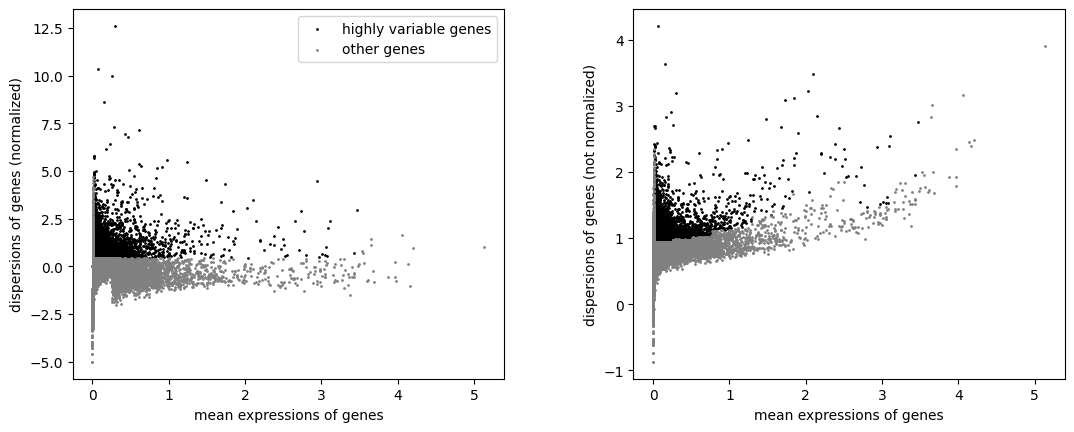

In [19]:
## identify highly variable genes.
sc.pp.highly_variable_genes(ht_adata_basal, min_mean=0.0125, max_mean=max_mean, min_disp=min_disp)
sc.pl.highly_variable_genes(ht_adata_basal)

## keep only highly variable genes:
ht_adata_basal = ht_adata_basal[:, ht_adata_basal.var['highly_variable']]

In [20]:
##Check the data
ht_adata_basal

View of AnnData object with n_obs × n_vars = 972 × 3133
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [21]:
##Save the 5Ht data after all preprocessing steps (if needed)
#ht_adata.write_h5ad('../data/ht5_preprocessed_intersection.h5ad')

# Find highly variable genes in the 6ho ADATA

/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:539: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


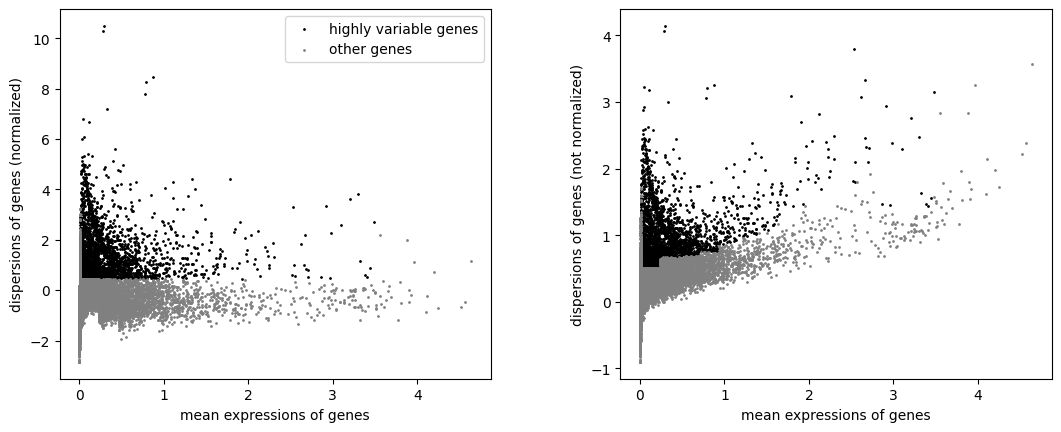

In [22]:
## identify highly variable genes.
sc.pp.highly_variable_genes(ho_adata_basal, min_mean=0.0125, max_mean=max_mean, min_disp=min_disp) #Absolute value of dispersionis taken, can be seen below.
sc.pl.highly_variable_genes(ho_adata_basal)

## keep only highly variable genes:
ho_adata_basal = ho_adata_basal[:, ho_adata_basal.var['highly_variable']]

In [23]:
##Check the data
ho_adata_basal

View of AnnData object with n_obs × n_vars = 516 × 2765
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [24]:
##Save the 6ho data after all preprocessing steps (if needed)
#ho_adata.write_h5ad('../data/ho6_preprocessed_intersection_.h5ad')

# Get HVGs_allbasal by taking unions of the all three sets of HVGs - combined, 5Ht, 6Ho

In [25]:
##Find union between 5ht and 6ho HVG
HVGs_basal_5ht_6ho = set(ht_adata_basal.var_names).union(ho_adata_basal.var_names)
HVGs_allbasal = HVGs_basal_5ht_6ho.union(adata_filtered_basal.var_names)

In [26]:
##Check the length of HVGs_allbasal
len(HVGs_allbasal) # 4885

4885

# Add DEG_TFs_allbasal which are not in HVGs_allbasal to create HVGs_network_basal

# Get final preprocessed data for network analysis

In [33]:
##Load the combined data
adata_filtered_basal = sc.read_h5ad('../../Processed_Data/combined_data_basal_5ht6ho_without_PTPRC_Adgre1_filtered.h5ad')
adata_filtered_basal

AnnData object with n_obs × n_vars = 1488 × 15321
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [34]:
## Subset to keep only highly variable genes:
adata_filtered_basal = adata_filtered_basal[:, HVGs_network_basal]

# # scale each gene to unit variance
sc.pp.scale(adata_filtered_basal)

adata_filtered_basal

/Users/weiwu2/anaconda3/envs/myenv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 1488 × 5088
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'percent.hb', 'umi_per_gene', 'RNA_snn_res.0.8', 'seurat_clusters', 'mt_filter', 'feature_filter', 'doublet_filter', 'qualtiy_filters', 'RNA_snn_res.0.5', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'S.Score', 'G2M.Score', 'cell_cycle_seurat', 'cluster1', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [35]:
## Save the data for network analysis
adata_filtered_basal.write_h5ad('../../Processed_Data/NetworkData_HVGs_basal_5ht6ho_without_PTPRC_Adgre1.h5ad')